In [41]:
#
# This code was downloded at https://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/
#
import numpy as np
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pylab as p
import cProfile
import pstats
import line_profiler as lp
from numba import jit, cuda


plt.interactive(True)
profiler = cProfile.Profile()
lineProfiler = lp.LineProfiler() #Initialize profiler

In [42]:
# The pressure Poisson equation that's written above can be hard to write out without typos. 
# The function build_up_b below represents the contents of the square brackets, 
# so that the entirety of the PPE is slightly more manageable.

def residuals(u,v,un,vn,dx,dy,dt):
    resU =  (u[1:-1, 1:-1] - un[1:-1, 1:-1]) / dt + \
            un[1:-1, 1:-1] * 1 / dx * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) + \
            vn[1:-1, 1:-1] * 1 / dy * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) + \
            1 / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) - \
            nu * ( \
            1 / dx**2 *(un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + \
            1 / dy**2 *(un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) # Square in each cell, normalize by rho * lidVelocity**2 * A, use scipy matrix solvers for matrix calculations

    resCont = (un[1:-1, 1:-1] - un[1:-1, 0:-2]) / dx + \
              (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) / dy


    resU = np.linalg.norm(resU,ord=2)
    resCont = np.linalg.norm(resCont,ord=2)
    resSumU = np.sum(np.abs(u-un))
    resSumV = np.sum(np.abs(v-vn))

    resSum = resSumU + resSumV

    return resU, resCont, resSum



def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

# The function pressure_poisson is also defined to help segregate the different rounds of calculations. Note the presence of the pseudo-time variable nit. This sub-iteration in the Poisson calculation helps ensure a divergence-free field.

def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

# Finally, the rest of the cavity flow equations are wrapped inside the function cavity_flow, allowing us to easily plot the results of the cavity flow solver for different lengths of time.

def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    print('cavity flow called: nt=',nt)
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    tol = np.sum(np.array([1e-2]))
    
    for n in range(nt):
            
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) - vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) + nu * (dt / dx**2 *(un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +dt / dy**2 *(un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +nu * (dt / dx**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) + dt / dy**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        """
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                        un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                        dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                        nu * (
                        dt / dx**2 *(un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        dt / dy**2 *(un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (
                        dt / dx**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        """

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0

        
        if (n+1) % 100 == 0:
            #resSum = np.sum((np.abs(u) - np.abs(un)) + (np.abs(v) - np.abs(vn)))
            resU, resCont, resSum = residuals(u,v,un,vn,dx,dy,dt)
            print(f"Iteration: {n+1},    resSum = {resSum:.4e}, resU = {resU:.4e}, resCont = {resCont:.4e}")
            if resCont < 1e-1 and n>2000:
                break
        

        
        
        
    return u, v, p

In [43]:
nx = 41
ny = 41
nt = 200000
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = 1e-6

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))


profiler_wrapper = lineProfiler(cavity_flow) #Create a wrapper for the function to be profiled

profiler.enable()
profiler_wrapper(nt, u, v, dt, dx, dy, p, rho, nu) #Call the wrapper
profiler.disable()






#Create statistics from the profiler, sorted by cumulative time
stats = pstats.Stats(profiler).sort_stats('cumtime')
#Print the 10 most expensive (inclusive) functions
stats.print_stats(10)


lineProfiler.print_stats() #Print the results


cavity flow called: nt= 200000
Iteration: 100,    resSum = 2.7944e-03, resU = 1.6824e-12, resCont = 9.9789e-02
Iteration: 200,    resSum = 3.0326e-03, resU = 3.0664e-12, resCont = 2.3989e-01
Iteration: 300,    resSum = 3.1398e-03, resU = 6.0241e-12, resCont = 3.8651e-01
Iteration: 400,    resSum = 3.1921e-03, resU = 6.6127e-12, resCont = 5.3432e-01
Iteration: 500,    resSum = 3.2208e-03, resU = 1.1639e-11, resCont = 6.8145e-01
Iteration: 600,    resSum = 3.2412e-03, resU = 1.1240e-11, resCont = 8.2709e-01
Iteration: 700,    resSum = 3.2593e-03, resU = 1.1415e-11, resCont = 9.7090e-01
Iteration: 800,    resSum = 3.2778e-03, resU = 1.2994e-11, resCont = 1.1127e+00
Iteration: 900,    resSum = 3.2927e-03, resU = 1.6599e-11, resCont = 1.2525e+00
Iteration: 1000,    resSum = 3.3035e-03, resU = 2.1342e-11, resCont = 1.3903e+00
Iteration: 1100,    resSum = 3.3104e-03, resU = 2.2874e-11, resCont = 1.5260e+00
Iteration: 1200,    resSum = 3.3137e-03, resU = 2.5288e-11, resCont = 1.6598e+00
Iterat

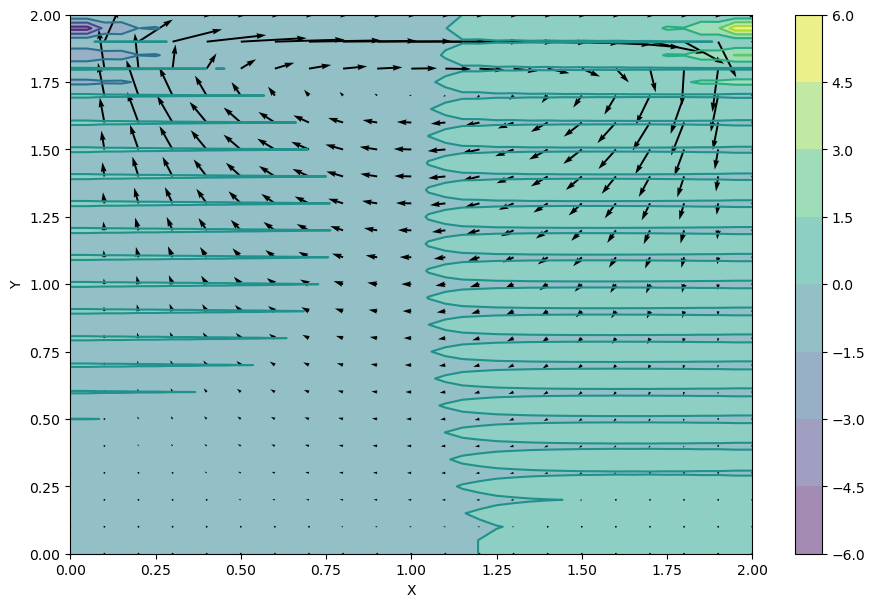

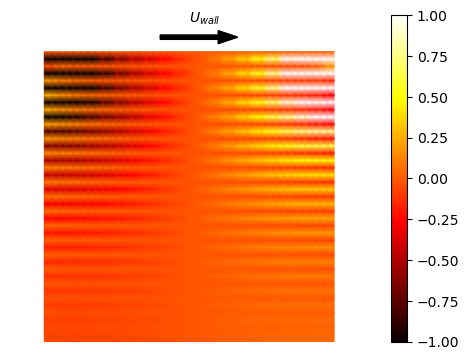

In [44]:

fig = pyplot.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# plotting the pressure field outlines
pyplot.contour(X, Y, p, cmap=cm.viridis)  
plt.savefig('p_NS.png',bbox_inches='tight')
# plotting velocity field
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
pyplot.xlabel('X')
pyplot.ylabel('Y');
plt.savefig('vect_NS.png',bbox_inches='tight')


########################################## iso u
fig1,ax1 = plt.subplots()
plt.subplots_adjust(left=0.20,bottom=0.20)
im=plt.pcolormesh(X,Y,p, vmin=-1,vmax=1,cmap=plt.get_cmap('hot'),shading='gouraud')
fig1.colorbar(im)
plt.arrow(x=0.8, y=2.1, dx=0.4, dy=0, width=.03,facecolor='black')
plt.text(1,2.2,'$U_{wall}$')
plt.axis('equal')
#plt.colorbar()
plt.axis('off')
plt.box(on=None)
plt.savefig('u_NS_iso.png')
